In [2]:
# Import required packages and modules
#======================================================================================================#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#======================================================================================================#


Bayes' Law provides a framework for understanding/inferring model parameters *given* some observations/data:

$$P(\theta\mid\mathbf{x}) = \frac{P(\mathbf{x}\mid\theta)\;P(\theta)}{P(\mathbf{x})},$$

where $\theta$ represent the model parameters, and $\mathbf{x}$ represent the data.

where,
$P(\mathbf{x}\mid\theta)$, the probability of the data given the model parameters, is the *likelihood*, $\mathcal{L}$.

$P(\theta)$, the probability of the model parameters, is the *prior*.

$P(\mathbf{x})$ the probability of the data, is the *evidence*.

Finally, $P(\theta\mid\mathbf{x})$, the probability of the model parameters given the data, is the *posterior*, $\pi$. 

$P(\mathbf{x})$ is a normalization term. 
Thus the posterior is $\propto \mathcal{L}\;P(\theta)$. We can maximize the posterior by maximizing the product of the likelihood times the prior.

## Simulate the Observation

We are drawing observations between 0 and 100 from a linear model with slope, $\rm m = 2.3$ and intercept $\rm b = 15$. We assume each observation is drawn from a Gaussian distribution with mean, $\rm \mu = 0$ and standard deviation, $\rm \sigma = 50$.

In [3]:
# Initialize random number
#======================================================================================================#
np.random.seed(200)
m_true = 2.3
b_true = 15
# Draw samples from a uniform distribution
x = np.random.uniform(low=0, high=100, size=40)
y_true = b_true + m_true*x
# Draw samples from a normal distribution with mean=0 and standard deviation=50
y_obs = y_true + np.random.normal(loc=0, scale=50, size=40)
# Return an array of ones with the same shape and type as a given array
y_unc = np.ones_like(y_obs)*50
#======================================================================================================#

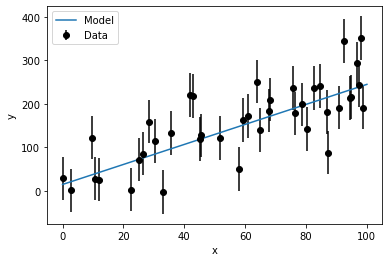

In [4]:
#%matplotlib notebook
#======================================================================================================#
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)


ax.errorbar(x, y_obs, y_unc, fmt='o', c='k', label='Data')
ax.plot([0,100], b_true+m_true*np.array([0,100]), label='Model')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='best');

#======================================================================================================#

- We can describe the probability of any individual observation as a function of the model parameters, assuming Gaussian distribution:
$$
p(y_i \mid m, b, x_i, \sigma_i) = \frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\exp{- \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}}
$$
where $y_i$ is the $i^\mathrm{th}$ observation, $x_i$ is the corresponding indpendent position at which $y_i$ is measured, $\sigma_{y_i}$ is the uncertainty on $y_i$; $m$ and $b$ are the slope and intercept for  the line.

- If the obseravtions are mutually independent, then the probability of all the observations is the product of the individual probabilities.
$$
\mathcal{L} = \prod_i p(y_i \mid m, b, x_i, \sigma_i) = \prod_i \frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\exp{- \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}}
$$

- Individual observations have really small probabilities, so the problem can become numerically unstable ( if we choose poor model parameters).

In order to circumvent this problem, we can convert the product into summations. 

$$
\log \mathcal{L} = \mathcal{K} - \sum_i \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}
$$

where $\mathcal{K}$ is a constant equal to $-\frac{n}{2}\log{2\pi} - \sum_i \log{\sigma_{y_i}}$.

$ \log \mathcal{L}$ is called the log-likelihood.

- The posterior will also require a knowledge of the prior. Priors can be selected from the model itself. But it also useful to select flat and uniform prior. While any value within the bounds of the prior are equally likely, values outside the bounds are unacceptable.

###======================================================================###
### The Metropolis-Hastings Algorithm
###======================================================================###

1. Pick some model parameter $\rm \theta_{0}$ from the parameter space and calculate the posterior $\rm P(\theta_{0} \mid \mathbf{x})$.
2. Propose a move from a current position $\theta_{i}$ to a new position $\theta_{i+1}$.
3. Calculate the posterior at $\rm \theta_{i+1}$,  $\rm P(\theta_{i+1} \mid \mathbf{x})$.
4. Draw a random number, $R \sim \mathcal{U}(0, 1)$.
5. If the ratio $\rm P(\theta_{i+1} \mid \mathbf{x})/P(\theta_{i} \mid \mathbf{x})$ is $>$ $R$, "accept" the proposed move and advance to $\theta_{i+1}$.
6. If not, "reject" the proposal and set $\rm \theta_{i+1} = \theta_{i}$.
7. Repeat from step 2, until chain is finished.

$\textbf{Note}$: The use of the random number is very essential to explore the full posterior. This is an important distinction relative to optimization routines that simply identify local maxima, but only proceeds in the direction of increased probability.


###======================================================================###

Calculate the Hastings ratio to know whether a proposal would be accepted or rejected.

$$H = \frac{\pi(\theta_{i+1})}{\pi(\theta_{i})} \frac{q(\theta_i \mid \theta_{i+1})}{q(\theta_{i+1} \mid \theta_{i})},$$

where $q(\theta_i \mid \theta_{i+1})/q(\theta_{i+1} \mid \theta_{i})$ is the ratio of transition probabilities from $\theta_{i+1}$ to $\theta_{i}$ and back again. 

If the proposals are symmetric, the ratio of transition probabilities is 1.

In [5]:
# Cell that contains the working functions of the code
#======================================================================================================#
def get_model_predictions(theta, x):
    
    '''
    Calculate the model value at each x-value.
    
    theta: Model parameters. (tuple)
    x: Array of values where y is measured.
    
    Returns: Array of model values
    '''
    m, b = theta
    model_preds = b + m*x
    
    return model_preds

#======================================================================================================#

def lnlikelihood(theta, x, y, y_unc):
    
    '''
    Calculate the log-likelihood of a model assuming Gaussian uncertainties.
    
    theta: Model parameters. (tuple)
    x: Array of independent variable.
    y: Array of observations at each x-value.
    y_unc: Uncertainty in y-value.
    
    Returns: The log-likelihood of the observations given the model parameters.
    
    '''
    
    model_preds = get_model_predictions(theta, x)
    
    lnl = -np.sum((y-model_preds)**2 / (2*y_unc**2))
    
    return lnl

#======================================================================================================#

def lnprior(theta):
    
    '''
    Calculate the log of the prior for the model parameters.
    
    theta: Model parameters. (tuple)
    
    Returns: the log-prior of the model parameters.
    
    For a uniform distribution.
    P(x) = 1/(b-a) within a half-open interval [a, b)
    
    '''
    
    m, b = theta
    if 0 <= m <= 300 and -100 <= b <= 100:
        # Assuming uniform prior
        lnp = np.log(1/300) + np.log (1/200) # Assumes p(m) and p(b) are independent
        
    else:
        return -np.inf
    
    return lnp

#======================================================================================================#

def lnposterior(theta, x, y, y_unc):
    
    '''
    Calculate the log posterior.
    
    theta: Model parameters. (tuple)
    x: Array of independent variable.
    y: Array of observations at each x-value.
    y_unc: Uncertainty in y-value.
    
    Returns: The log-posterior from the observation and model parameters.
    '''
    
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlikelihood(theta, x, y, y_unc)
    
    lnpost = lnl + lnp
    
    return lnpost

#======================================================================================================#

def hastings_ratio(theta_1, theta_0, x, y, y_unc):
    
    '''
    Function to calculate the Hastings ratio..
    
    theta_1: proposed new posterior position (tuple).
    theta_0: current posterior position (tuple).
    x: Array of independent variable.
    y: Array of observations at each x-value.
    y_unc: Uncertainty in y-value.
    
    Returns: The Hastings ratio.
    '''
    
    lnpost1 = lnposterior(theta_1, x, y, y_unc)
    lnpost0 = lnposterior(theta_0, x, y, y_unc)
    
    h_ratio = np.exp(lnpost1)/np.exp(lnpost0)
    
    return h_ratio

#======================================================================================================#

def propose_jump(theta, cov):
    
    if np.shape(theta) == np.shape(cov):
        cov = np.diag(np.array(cov)**2)
        
    # Draw random samples from a multivariate normal distribution.
    proposed_position = np.random.multivariate_normal(mean=theta, cov=cov)
    
    return proposed_position

#======================================================================================================#

def mh_mcmc(theta, cov, nsteps, x, y, y_unc):
    
    positions = np.zeros((nsteps+1, len(theta)))
    lnpost_at_pos = -np.inf*np.ones(nsteps+1)
    acceptance_ratio = np.zeros_like(lnpost_at_pos)
    accepted = 0
    
    positions[0] = theta
    lnpost_at_pos[0] = lnposterior(theta, x, y, y_unc)
    
    for step_num in np.arange(1, nsteps+1):
        
        proposal = propose_jump(positions[step_num-1], cov)
        H = hastings_ratio(proposal, positions[step_num-1], x, y, y_unc)
        R = np.random.uniform()
        
        if H > R:
            accepted += 1
            positions[step_num] = proposal
            lnpost_at_pos[step_num] = lnposterior(proposal, x, y, y_unc)
            acceptance_ratio[step_num] = float(accepted)/step_num
            
        else:
            positions[step_num] = positions[step_num-1]
            lnpost_at_pos[step_num] = lnpost_at_pos[step_num-1]
            acceptance_ratio[step_num] = float(accepted)/step_num
    
    
    return (positions, lnpost_at_pos, acceptance_ratio)

#======================================================================================================#

def plot_posterior(theta, cov, nsteps, x, y, y_unc):
    
    pos, lnpost, acc_ratio = mh_mcmc(theta, cov, nsteps, x, y, y_unc)
    
    # plt.subplots(row, column)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    plt.subplots_adjust(wspace=0.3)
    
    ax1.plot(pos[:,0], pos[:,1], 'o-', alpha=0.2)
    ax1.plot(2.3, 15, '*', ms=35, mfc='red', mec='orange', mew=2, alpha=0.5)
    ax1.set_xlabel('m', fontsize=14)
    ax1.set_ylabel('b', fontsize=14)
    
    ax2.plot(pos[:, 0], pos[:, 1], 'o-', alpha=0.3)
    cax = ax2.scatter(pos[:, 0], pos[:, 1], c=lnpost, cmap='cividis', zorder=5)
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(r'$\rm \log\ \pi (\theta)$', fontsize = 15)
    
    ax2.set_xlabel('m', fontsize=14)
    ax2.set_ylabel('b', fontsize=14)
    
#======================================================================================================#
    
def plot_mcmc_summary(theta, cov, nsteps, x, y, y_unc):
    
    pos, lnpost, acc_ratio = mh_mcmc(theta, cov, nsteps, x, y, y_unc)
    
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.subplot2grid((4,5), (0,0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((4,5), (2,0), colspan=2, rowspan=2)
    ax3 = plt.subplot2grid((4,5), (0,2), colspan=3)
    ax4 = plt.subplot2grid((4,5), (1,2), colspan=3, sharex=ax3)
    ax5 = plt.subplot2grid((4,5), (2,2), colspan=3, sharex=ax3)
    ax6 = plt.subplot2grid((4,5), (3,2), colspan=3, sharex=ax3)
    
    ax1.hexbin(pos[:,0], pos[:,1], gridsize=50, mincnt=1, bins='log')
    ax1.plot(2.3, 15, '*', ms=35, mfc='red', mec='orange', mew=2, alpha=0.5)
    
    xlims = ax1.get_xlim()
    ylims = ax1.get_ylim()
    ax1.plot(xlims, [15, 15], 'Crimson', alpha=0.3)
    ax1.plot([2.3, 2.3], ylims, 'Crimson', alpha=0.3)
    ax1.set_xlim(xlims)
    ax1.set_ylim(ylims)
    ax1.set_xlabel('m')
    ax1.set_ylabel('b')
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.tick_params(top=True, bottom=False)
    
    ax2.errorbar(x, y, y_unc, fmt='o')
    
    for draw in np.random.choice(len(pos), 10, replace=False):
        ax2.plot([0,100], pos[draw,1] + pos[draw,0]*np.array([0,100]),
                 'DarkOrange', alpha=0.5)
        
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
    ax3.plot(pos[:,0])
    ax3.set_ylabel('m')
    
    ax4.plot(pos[:,1])
    ax4.set_ylabel('b')
    
    ax5.plot(lnpost)
    ax5.set_ylabel('$\ln \; \pi$')
    
    ax6.plot(acc_ratio)
    ax6.set_ylabel('acceptance')
    ax6.set_xlabel('step number')
    
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    plt.setp(ax5.get_xticklabels(), visible=False)
    
    fig.subplots_adjust(top=0.93, left=0.09, right=0.99, hspace=0.07,
                       wspace=0.75)
    
#======================================================================================================#    

In [6]:
# Calculate the ln likelihood for two set of model parameters:
# One is same as the true model paramte

print ('ln L for m=1.5 and b=40 is: {:.4f}'.format(lnlikelihood((1.5, 40), x, y_obs, y_unc)))
print ('ln L for m=2.3 and b=15 is: {:.4f}'.format(lnlikelihood((2.3, 15), x, y_obs, y_unc)))

ln L for m=1.5 and b=40 is: -37.0973
ln L for m=2.3 and b=15 is: -26.2847


$\textbf{Note}$: The true model values gives a higher value of likelihood.

In [7]:
# Calculate log prior for different set of model parameters
print ('ln P for m=1.5 and b=50 is: {:.4f}'.format(lnprior((1.5, 50))))
print ('ln P for m=-1 and b=50 is: {:.4f}'.format(lnprior((-1, 50))))
print ('ln P for m=1.5 and b=-150 is: {:.4f}'.format(lnprior((1.5, -150))))
print ('ln P for m=2.3 and b=15 is: {:.4f}'.format(lnprior((2.3, 15))))


ln P for m=1.5 and b=50 is: -11.0021
ln P for m=-1 and b=50 is: -inf
ln P for m=1.5 and b=-150 is: -inf
ln P for m=2.3 and b=15 is: -11.0021


$\textbf{Note}$: For model parameters within the bounds of the prior all values are equally likely. Whereas there is no probability for model parameters outside bounds.

In [12]:
print ('ln posterior for m=1.5 and b=40 is: {:.4f}'.format(lnposterior((1.5, 40), x, y_obs, y_unc)))
print ('ln posterior for m=2.3 and b=15 is: {:.4f}'.format(lnposterior((2.3, 15), x, y_obs, y_unc)))
print ('ln posterior for m=-1 and b=40 is: {:.4f}'.format(lnposterior((-1, 40), x, y_obs, y_unc)))
print ('ln posterior for m=1.5 and b=200 is: {:.4f}'.format(lnposterior((1.5, 200), x, y_obs, y_unc)))


ln posterior for m=1.5 and b=40 is: -48.0994
ln posterior for m=2.3 and b=15 is: -37.2868
ln posterior for m=-1 and b=40 is: -inf
ln posterior for m=1.5 and b=200 is: -inf


$\textbf{Note}$: The posterior values are (log prior + log likelihood). There is no probability outside the prior.

In [9]:
# Calculates the Hastings ratio to move from model parameter (2.1, 50) to (2.2, 30)
print ('The Hastings ratio is: {:.4f}'.format(hastings_ratio((2.2, 30), (2.1, 50), x, y_obs, y_unc)))

The Hastings ratio is: 5.9752


$\textbf{Note}$: In the above case the H-ratio is > 1 and hence the proposed move would be accepted every time.

In [10]:
# Calculate the reverse proposal to move from (2.2, 30) to (2.1, 50)
print ('The Hastings ratio is: {:.4f}'.format(hastings_ratio((2.1, 50), (2.2, 30), x, y_obs, y_unc)))

The Hastings ratio is: 0.1674


$\textbf{Note}$: In the above case, H-ratio < 1, and thus the proposed move would be accepted only if R < 0.1674. 

In [11]:
theta_0 = (2, 45)

for _ in range(5):
    new_pos = propose_jump(theta_0, (0.1, 10))
    H_ratio = hastings_ratio(new_pos, theta_0, x, y_obs, y_unc)
    print ('Jumping to {}, gives H-ratio = {:.4f}'.format(new_pos, H_ratio))

Jumping to [ 2.09782361 42.05342726], gives H-ratio = 1.0695
Jumping to [ 1.93134766 44.69919578], gives H-ratio = 0.8313
Jumping to [ 2.13376414 45.49740172], gives H-ratio = 0.5150
Jumping to [ 2.05537018 42.67232101], gives H-ratio = 1.1274
Jumping to [ 2.11927979 29.7992592 ], gives H-ratio = 1.2784


In [12]:
%time
pos, lnpost, acc_ratio = mh_mcmc((2.7, -70), (0.25, 5), 1000, x, y_obs, y_unc)


CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 18.1 µs


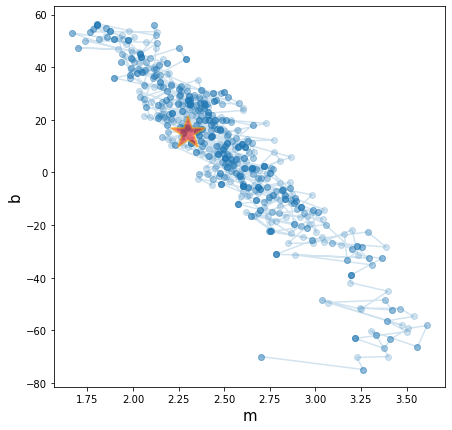

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(pos[:,0], pos[:,1], 'o-', alpha=0.2)
# Plot the true value
ax.plot(2.3, 15, '*', ms=35, mfc='red', mec='orange', mew=2, alpha=0.5)
ax.set_xlabel('m', fontsize=15)
ax.set_ylabel('b', fontsize=15);

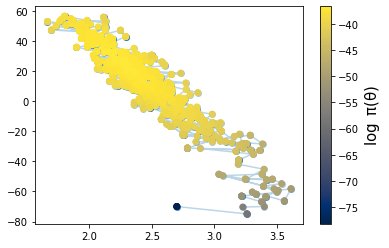

In [14]:
fig, ax = plt.subplots()
ax.plot(pos[:, 0], pos[:, 1], 'o-', alpha=0.3)
cax = plt.scatter(pos[:, 0], pos[:, 1], c=lnpost, cmap='cividis', zorder=3)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel(r'$\rm \log\ \pi (\theta)$', fontsize=15);

In [15]:
%time
pos, lnpost, acc_ratio = mh_mcmc((2.7, -70), (0.25, 5), 50, x, y_obs, y_unc)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 13.8 µs


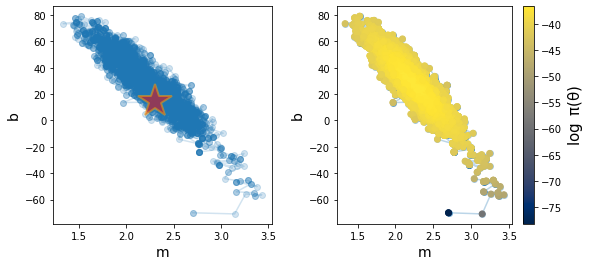

In [16]:
plot_posterior((2.7, -70), (0.25, 5), 5000, x, y_obs, y_unc)

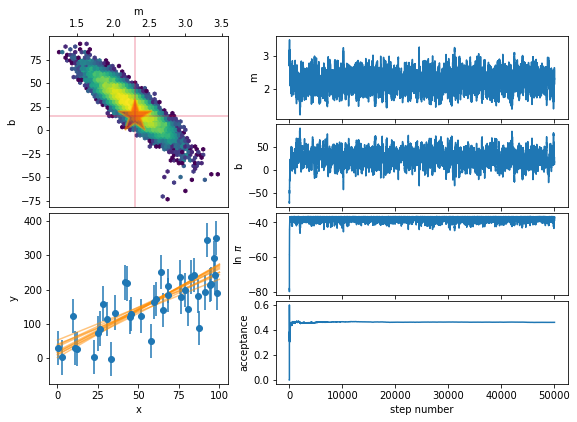

In [17]:
plot_mcmc_summary((2.7, -70), (0.25, 5), 50000, x, y_obs, y_unc)